In [1]:
import scipy.integrate as integrate
import scipy.special as special
from numpy import sqrt, exp, pi, log
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from pydtmc import MarkovChain
import seaborn as sns
from scipy.linalg import expm
np.random.seed(42)
plt.style.use("dark_background")

In [2]:
def TVaR(arr,a):
    edge = np.array(sorted(arr)[int(a*len(arr)):])
    return edge.mean()

In [3]:
mu = 0.5
nu = 0.5

r = 0.03
alpha = [0.02, 0.07]
sigma_l = 0.10
sigma_h = 0.30

pi_1 = pi_2 = 0.5
t = 0
T = 10
h = 1/12
inf = 0.02

## Expense Assumptions
ED = 15
ES = 15
EIF = 75
commish = 0.05

## Guarantee Conditions
F0 = 100000
GMMB = F0 * 1.2
fee = [0.028165,0.033103]

beta = 0
GMDB = 1.1*F0

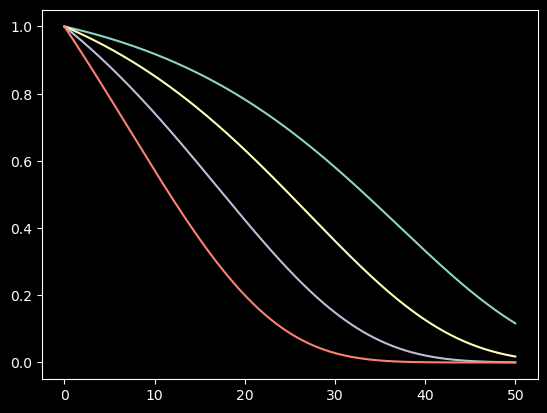

In [4]:
## Mortality Modeling

A = 0.0001
B = 0.00026
c = 1.065
def mort(x):
    return A + B*pow(c,x)
def p(t,x):
    F = B*pow(c,x)/log(c)
    return exp(-(A*t + F*(pow(c,t)-1)))

plt.plot([t/100 for t in range(0,5000)],[p(t/100,50) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,60) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,70) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,80) for t in range(0,5000)])
plt.show()

In [5]:
def e(x):
    E = 0
    for t in range(int(120-x)):
        E += p(t,x)
    return E
np.array([e(0),e(50),e(60),e(70)]).round(2)

array([78.57, 32.92, 25.32, 18.68])

In [6]:
## Surrender Modeling

def surrender(t):
    
    if t <= 1:
        return [0.0050, 0.90]
    elif t <= 2:
        return [0.0100, 0.92]
    elif t <= 3:
        return [0.0150, 0.94]
    elif t <= 4:
        return [0.0150, 0.96]
    
    ## Surrender Ends
    
    elif t <= 5:
        return [0.3000, 1.00]
    
    elif t <= 6:
        return [0.1500, 1.00]
    elif t <= 7:
        return [0.1000, 1.00]
    elif t <= 8:
        return [0.0750, 1.00]
    elif t <= 9:
        return [0.0700, 1.00]
    elif t <= 10:
        return [0.0600, 1.00]
    else:
        return [0.0450, 1.00]

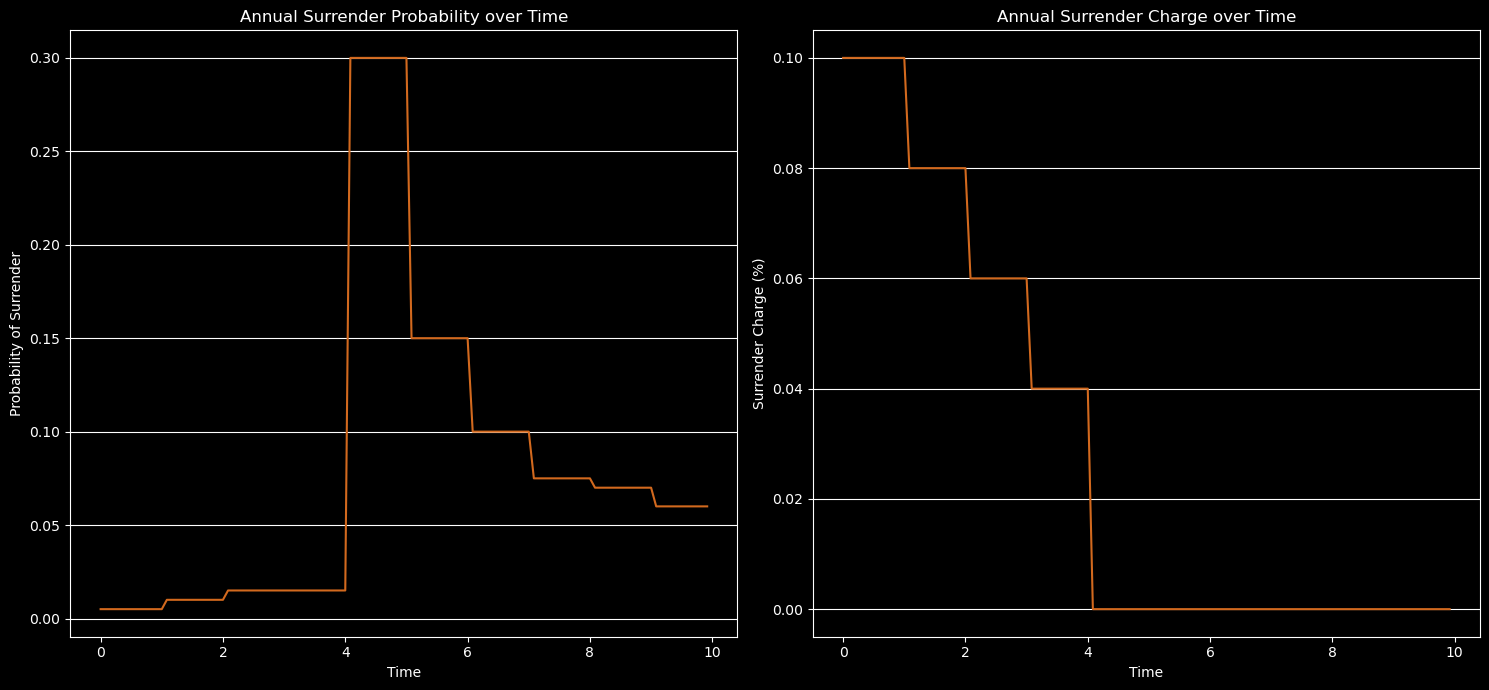

In [7]:
time = [h*t for t in range(int(T/h))]
fig, ax1 = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(15)
fg_color = "white"

im1 = ax1[0].plot(time,[surrender(t)[0] for t in time], c = "chocolate")

# IMSHOW    
# set title plus title color
ax1[0].set_title('Annual Surrender Probability over Time', color=fg_color)
ax1[0].set_xlabel("Time",c="white")
ax1[0].set_ylabel("Probability of Surrender",c="white")
ax1[0].grid(axis="y")


im2 = ax1[1].plot(time,[1 - surrender(t)[1] for t in time], c = "chocolate")

# IMSHOW    
# set title plus title color
ax1[1].set_title('Annual Surrender Charge over Time', color=fg_color)
ax1[1].set_xlabel("Time",c="white")
ax1[1].set_ylabel("Surrender Charge (%)",c="white")
ax1[1].grid(axis="y")
   
plt.tight_layout()
plt.show()

In [8]:
mu = 0.5
nu = 0.5
Tr_Mat = [[-mu,mu],
          [nu,-nu]]
P = expm(Tr_Mat)
p12 = exp(-mu*h)
p21 = exp(-nu*h)
## Initial Probabilities
pi_1 = p21 / (p12 + p21)
pi_2 = p12 / (p12 + p21)
pi_1,pi_2
mc = MarkovChain(P,["0","1"])
#sum([sum([int(x) for x in mc.simulate(10*52)]) / (10*52) for n in range(500)])/500,
P

array([[0.68393972, 0.31606028],
       [0.31606028, 0.68393972]])

In [9]:
%%time 
## Creating market sample paths
T = 10
h = 1/12
M = int(T/h) ## Length of sims
N = 1000 ## Number of sims
P = 500
regime_states = [mc.simulate(steps=M) for n in range(N)] ## len M + 1

variates = [norm.rvs(size=M+1) for n in range(N)]


stc = 0.5*sigma_l + 0.5*sigma_h
rtc = r

LIABILITIES = []
LIABILITIES_COMPARISON = []

FUNDS = []
FUNDS_COMPARISON = []

dead = []
surr = []
for n in range(N):
    
    ## initial age of policyholders
    ph_ages = np.random.normal(67.5,2,size=P)

    Liab = commish*F0*len(ph_ages)
    Liab_comp = commish*F0*len(ph_ages)

    liability_over_time = [Liab]
    liability_comp_over_time = [Liab_comp]

    GR = []
    WF = []

    F = F0
    F_comp = F0

    fund_value = [F]
    fund_value_comp = [F_comp]

    for k in range(M+1):
        ## Market Model
        if regime_states[n][k] == "0":
            f = exp((r-fee[0]-0.5*sigma_l**2)*h+sigma_l*h*variates[n][k])
            F *= f
            fund_value.append(F)
        else:
            f = exp((r-fee[0]-0.5*sigma_h**2)*h+sigma_h*h*variates[n][k])
            F *= f
            fund_value.append(F)
        F_comp *= exp((rtc-fee[1]-0.5*stc**2)*h+stc*h*variates[n][k])
        fund_value_comp.append(F_comp)

        ## who died?
        grim_reaper = [np.random.random() > p(h,x) for x in ph_ages]
        ## who left
        white_flag = [np.random.random() < surrender(k*h)[0]*h for x in ph_ages]
        new_ph = []
        for i in range(len(ph_ages)):
            if not (grim_reaper[i] or white_flag[i]):
                new_ph.append(ph_ages[i])
        ph_ages = np.array(new_ph)
        ## update liability
        Liab += exp(-r*(T - k*h))*(GMDB*exp(beta*k*h)+ ED *h* exp(inf*k*h))*sum(grim_reaper)
        Liab += exp(-r*(T - k*h))*(F*surrender(k*h)[1] + ES *h* exp(inf*k*h))*sum(np.delete(white_flag,grim_reaper))  ## filter out dead & surrendered
        Liab += exp(-r*(T - k*h))*(EIF *h* exp(inf*k*h) * len(ph_ages))
        liability_over_time.append(Liab)

        Liab_comp += exp(-r*(T - k*h))*(GMDB*exp(beta*k*h)+ ED *h* exp(inf*k*h))*sum(grim_reaper)
        Liab_comp += exp(-r*(T - k*h))*(F_comp*surrender(k*h)[1] + ES *h* exp(inf*k*h))*sum(np.delete(white_flag,grim_reaper))  ## filter out dead & surrendered
        Liab_comp += exp(-r*(T - k*h))*(EIF *h* exp(inf*k*h) * len(ph_ages))
        liability_comp_over_time.append(Liab_comp)


        ph_ages = ph_ages + h
        GR.append(sum(grim_reaper))
        WF.append(sum(np.delete(white_flag,grim_reaper)))
        ## update policyholder list
    liability_comp_over_time = np.array(liability_comp_over_time)
    liability_over_time = np.array(liability_over_time)
    liability_over_time[-1] += max(GMMB,F)*len(ph_ages)
    liability_comp_over_time[-1] += max(GMMB,F_comp)*len(ph_ages)
    
    LIABILITIES.append(liability_over_time)
    LIABILITIES_COMPARISON.append(liability_comp_over_time)

    FUNDS.append(np.array(fund_value))
    FUNDS_COMPARISON.append(np.array(fund_value_comp))
    dead.append(GR)
    surr.append(WF)

CPU times: total: 3min 16s
Wall time: 4min 35s


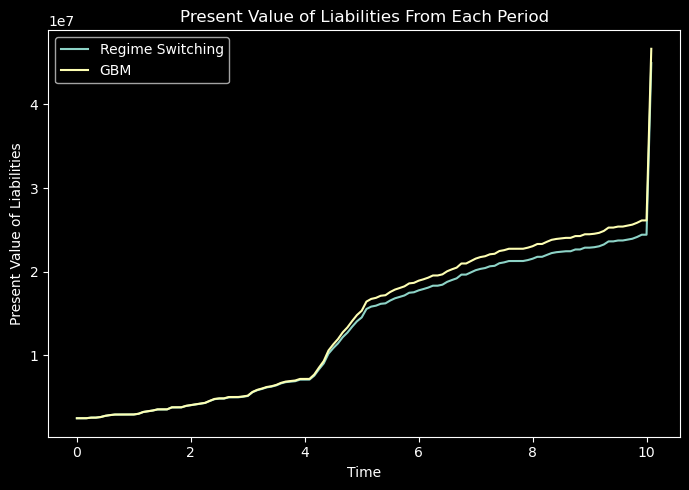

In [10]:
fig, ax1 = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
fg_color = 'white'
bg_color = 'black'

im1 = ax1.plot([k*h for k in range(M+2)],LIABILITIES[8])
im2 = ax1.plot([k*h for k in range(M+2)],LIABILITIES_COMPARISON[8])
# IMSHOW    
# set title plus title color
ax1.set_title('Present Value of Liabilities From Each Period', color=fg_color)
ax1.set_xlabel("Time",c="white")
ax1.set_ylabel("Present Value of Liabilities",c="white")
ax1.legend(["Regime Switching","GBM"]) 


fig.patch.set_facecolor(bg_color)    
plt.tight_layout()
plt.show()

In [14]:
%%time
np.random.seed(17)
## Creating market sample paths
T = 10
h = 1/12
M = int(T/h) ## Length of sims
N = 1000 ## Number of sims
P = 500
regime_states = [mc.simulate(steps=M) for n in range(N)] ## len M + 1

variates = [norm.rvs(size=M+1) for n in range(N)]


stc = 0.5*sigma_l + 0.5*sigma_h
rtc = r
atc = sum(alpha) / 2
LIABILITIES = []
LIABILITIES_COMPARISON = []

FUNDS = []
FUNDS_COMPARISON = []

dead = []
surr = []
for n in range(N):
    
    ## initial age of policyholders
    ph_ages = np.random.normal(67.5,2,size=P)

    Liab = commish*F0*len(ph_ages)
    Liab_comp = commish*F0*len(ph_ages)

    liability_over_time = [Liab]
    liability_comp_over_time = [Liab_comp]

    GR = []
    WF = []

    F = F0
    F_comp = F0

    fund_value = [F]
    fund_value_comp = [F_comp]

    for k in range(M+1):
        ## Market Model
        if regime_states[n][k] == "0":
            f = exp((alpha[0]-fee[0]-0.5*sigma_l**2)*h+sigma_l*h*variates[n][k])
            F *= f
            fund_value.append(F)
        else:
            f = exp((alpha[1]-fee[0]-0.5*sigma_h**2)*h+sigma_h*h*variates[n][k])
            F *= f
            fund_value.append(F)
        F_comp *= exp((atc-fee[1]-0.5*stc**2)*h+stc*h*variates[n][k])
        fund_value_comp.append(F_comp)

        ## who died?
        grim_reaper = [np.random.random() > p(h,x) for x in ph_ages]
        ## who left
        white_flag = [np.random.random() < surrender(k*h)[0]*h for x in ph_ages]
        new_ph = []
        for i in range(len(ph_ages)):
            if not (grim_reaper[i] or white_flag[i]):
                new_ph.append(ph_ages[i])
        ph_ages = np.array(new_ph)
        ## update liability
        Liab += exp(-r*(T - k*h))*(GMDB*exp(beta*k*h)+ ED *h* exp(inf*k*h))*sum(grim_reaper)
        Liab += exp(-r*(T - k*h))*(F*surrender(k*h)[1] + ES *h* exp(inf*k*h))*sum(np.delete(white_flag,grim_reaper))  ## filter out dead & surrendered
        Liab += exp(-r*(T - k*h))*(EIF *h* exp(inf*k*h) * len(ph_ages))
        liability_over_time.append(Liab)

        Liab_comp += exp(-r*(T - k*h))*(GMDB*exp(beta*k*h)+ ED *h* exp(inf*k*h))*sum(grim_reaper)
        Liab_comp += exp(-r*(T - k*h))*(F_comp*surrender(k*h)[1] + ES *h* exp(inf*k*h))*sum(np.delete(white_flag,grim_reaper))  ## filter out dead & surrendered
        Liab_comp += exp(-r*(T - k*h))*(EIF *h* exp(inf*k*h) * len(ph_ages))
        liability_comp_over_time.append(Liab_comp)


        ph_ages = ph_ages + h
        GR.append(sum(grim_reaper))
        WF.append(sum(np.delete(white_flag,grim_reaper)))
        ## update policyholder list
    liability_comp_over_time = np.array(liability_comp_over_time)
    liability_over_time = np.array(liability_over_time)
    liability_over_time[-1] += max(GMMB,F)*len(ph_ages)
    liability_comp_over_time[-1] += max(GMMB,F_comp)*len(ph_ages)
    
    LIABILITIES.append(liability_over_time)
    LIABILITIES_COMPARISON.append(liability_comp_over_time)

    FUNDS.append(np.array(fund_value))
    FUNDS_COMPARISON.append(np.array(fund_value_comp))
    dead.append(GR)
    surr.append(WF)

CPU times: total: 3min 15s
Wall time: 4min 43s


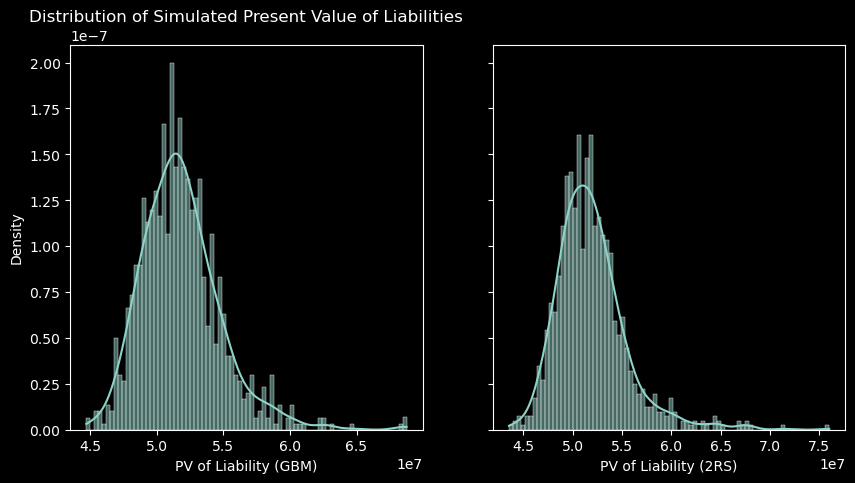

In [23]:
K = 80
fig, ax1 = plt.subplots(1,2,sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
sns.histplot(sorted(np.array([LIABILITIES_COMPARISON[i][-1] for i in range(N)])), bins=K, ax = ax1[0],kde=True,stat="density")
ax1[0].set_title('Distribution of Simulated Present Value of Liabilities', color=fg_color)
ax1[0].set_xlabel("PV of Liability (GBM)",c="white")

sns.histplot(sorted(np.array([LIABILITIES[i][-1] for i in range(N)])), bins=K, ax = ax1[1],kde=True,stat="density")
ax1[1].set_xlabel("PV of Liability (2RS)",c="white")
plt.show()

In [25]:
A1 = np.array([LIABILITIES_COMPARISON[i][-1] for i in range(N)]).mean()
A2 = np.array([LIABILITIES[i][-1] for i in range(N)]).mean()
Q = [0.9,0.95,0.99]
a1 = np.array([LIABILITIES_COMPARISON[i][-1] for i in range(N)])
a2 = np.array([LIABILITIES[i][-1] for i in range(N)])
print([np.array([TVaR(a1,q) / a1.mean(), np.quantile(a1,q)/a1.mean(), TVaR(a2,q) / a2.mean(), np.quantile(a2,q)/a2.mean()]).round(2) for q in Q])


[array([1.12, 1.07, 1.15, 1.07]), array([1.15, 1.1 , 1.2 , 1.12]), array([1.24, 1.17, 1.31, 1.25])]
